Read the Shapefile from the City data and the temperature data.

In [73]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import pandas as pd
import numpy as np
from shapely.geometry import mapping

# Laden des Shapefiles mit den Städteumrissen
cities_gdf = gpd.read_file("input/Morphological_Urban_Area.shp")

# Listen der Monate und Temperaturtypen
temp_types = ["tas", "tasmax", "tasmin"]
months = [f"{i:02d}" for i in range(1, 13)]  # Liste der Monate als Strings "01" bis "12"
year = "2071_2100"  # Das Jahr bleibt konstant "1981-2010"

def extract_temperature_and_coordinates(city_shape, raster, transform, scale=1, kelvin_to_celsius=True):
    """Extrahiert Temperaturwerte und Koordinaten für eine Stadt."""
    # Bereite die Geometrie der Stadt vor
    geo = [mapping(city_shape)]
    out_image, out_transform = mask(raster, geo, crop=True)
    
    # Extrahiere die Temperaturdaten (ohne NoData-Werte)
    temp_values = out_image[out_image != raster.nodata]
    
    # Wende den Maßstab an (z.B. 0.1)
    temp_values = temp_values * scale
    
    # Falls die Werte in Kelvin sind, konvertiere sie in Celsius
    if kelvin_to_celsius:
        temp_values = temp_values - 273.15

    # Berechne die Koordinaten nur für die Maskengeometrie
    row_inds, col_inds = np.where(out_image[0] != raster.nodata)
    coords = [rasterio.transform.xy(out_transform, row, col) for row, col in zip(row_inds, col_inds)]
    
    return temp_values, coords

# Iteriere über Temperaturtypen und Monate
for temp_type in temp_types:
    for month in months:
        # Erstelle den Namen der Klimadatei basierend auf Temperaturtyp, Monat und Jahr
        #name_climate = f"input/CHELSA_{temp_type}_{month}_{year}_V.2.1.tif"
        name_climate = f"input/CHELSA_mpi-esm1-2-hr_r1i1p1f1_w5e5_ssp126_{temp_type}_{month}_{year}_norm.tif"

        # Bereite eine Liste für die Ergebnisse vor
        results = []
        
        # Iteriere über jede Stadt und extrahiere Temperaturwerte und Pixelkoordinaten
        with rasterio.open(name_climate) as temp_raster:
            # Maßstab: 0.1 (wie in QGIS angegeben)
            scale = 0.1
            transform = temp_raster.transform  # Transformation der Rasterdaten
            
            for index, city in cities_gdf.iterrows():
                temp_values, pixel_coords = extract_temperature_and_coordinates(city.geometry, temp_raster, transform, scale=scale, kelvin_to_celsius=True)
                
                # Füge Ergebnisse in ein DataFrame
                results.append({
                    "Country_name": city['Cntry__'],
                    "city_name": city['Aggname'],
                    "temperature_values": temp_values,
                    "pixel_coordinates": pixel_coords,
                    "geometry": city.geometry
                })
        
        # Erstelle ein GeoDataFrame mit den Ergebnissen
        temp_gdf = gpd.GeoDataFrame(results)
        
        # Berechne den höchsten Temperaturwert pro Stadt
        temp_gdf['max_temperature'] = temp_gdf['temperature_values'].apply(lambda x: np.nanmax(x) if len(x) > 0 else np.nan)
        
        # Bereite eine Liste für die flache Struktur vor
        flattened_data = []
        
        # Iteriere über das GeoDataFrame, um die Listen von Pixelkoordinaten und Temperaturen zu flachen Zeilen zu transformieren
        for index, row in temp_gdf.iterrows():
            city_name = row['city_name']
            country_name = row['Country_name']
            coords = row['pixel_coordinates']
            temps = row['temperature_values']
            
            # Falls es Koordinaten und Temperaturwerte gibt, füge sie einzeln hinzu
            for coord, temp in zip(coords, temps):
                x, y = coord  # Extrahiere x und y Koordinaten
                flattened_data.append({
                    "City": city_name,
                    "Country": country_name,
                    "x-Koord": x,
                    "y-Koord": y,
                    "Temp": temp
                })
        
        # Erstelle ein neues DataFrame aus der flachen Liste
        flattened_df = pd.DataFrame(flattened_data)
        
        # Optional: Speichern als CSV oder in einem anderen Format
        output_filename = f"output/flattened_city_temperature_data_126_{temp_type}_{month}_{year}.csv"
        flattened_df.to_csv(output_filename, index=False)
        print(f"Gespeichert: {output_filename}")


Gespeichert: output/flattened_city_temperature_data_126_tas_01_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_02_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_03_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_04_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_05_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_06_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_07_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_08_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_09_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_10_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_11_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tas_12_2071_2100.csv
Gespeichert: output/flattened_city_temperature_data_126_tasmax_01_2071_2100.

In [74]:
import pandas as pd
import glob
import os

# Verzeichnis, in dem die CSV-Dateien gespeichert sind
csv_folder = "output/"

# Verwende glob, um alle CSV-Dateien im Ordner zu finden
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))

year = "2071_2100"
# Liste zum Speichern der einzelnen DataFrames
df_list = []

# Iteriere über die gefundenen CSV-Dateien und lade sie in Pandas DataFrames
for file in csv_files:
    # Lese jede CSV-Datei ein
    df = pd.read_csv(file)
    
    # Extrahiere den Temperaturtyp und Monat aus dem Dateinamen
    filename = os.path.basename(file)  # Nur den Dateinamen ohne Pfad nehmen
    parts = filename.split('_')  # Teile den Dateinamen anhand von '_'
    
    # Temperaturtyp (z.B. tas, tasmax, tasmin)
    temp_type = parts[5]  # Der Temperaturtyp steht an 4. Stelle
    
    # Monat (z.B. 01, 02, ..., 12)
    month = parts[6]  # Der Monat steht an 5. Stelle
    spp = parts[4]
    
    # Füge den Temperaturtyp und den Monat als neue Spalten hinzu
    df['Temp_Type'] = temp_type
    df['Monat'] = month
    df['SPP'] = spp
    
    # Füge den DataFrame der Liste hinzu
    df_list.append(df)

# Führe alle DataFrames zu einem großen DataFrame zusammen
combined_df = pd.concat(df_list, ignore_index=True)

# Entferne alle Zeilen, die einen negativen Temperaturwert ("Temp" < 0) besitzen
combined_df = combined_df[combined_df["Temp"] > -273.15]

# Optional: Speichere das kombinierte DataFrame in eine neue CSV-Datei
combined_df.to_csv(f"output/combined_temperature_data_126_cleaned_with_types_{year}.csv", index=False)

# Optional: Ausgabe des DataFrame
print(combined_df.head())


       City Country    x-Koord    y-Koord   Temp Temp_Type Monat  SPP
0  Winnipeg  Canada -97.187639  49.979027  16.95    tasmin    07  126
1  Winnipeg  Canada -97.162639  49.979027  16.95    tasmin    07  126
2  Winnipeg  Canada -97.154306  49.979027  16.95    tasmin    07  126
3  Winnipeg  Canada -97.145973  49.979027  16.95    tasmin    07  126
4  Winnipeg  Canada -97.137639  49.979027  16.95    tasmin    07  126


In [62]:
import pandas as pd

# Dateien einlesen
df1 = pd.read_csv('output/total/combined_temperature_data_cleaned_with_types_1981_2010.csv')
df2 = pd.read_csv('output/total/combined_temperature_data_585_cleaned_with_types_2011_2040.csv')
df3 = pd.read_csv('output/total/combined_temperature_data_585_cleaned_with_types_2041_2070.csv')
df4 = pd.read_csv('output/total/combined_temperature_data_585_cleaned_with_types_2071_2100.csv')

# Datenrahmen basierend auf Koordinaten, Monat und Temperaturtyp zusammenführen (innerer Join auf x-Koord, y-Koord, Monat und Temp_Type)
merged_df = pd.merge(df1, df2, on=['x-Koord', 'y-Koord', 'Monat', 'Temp_Type'], suffixes=('_1981_2010', '_2011_2040'))
print("Nach dem ersten Merge:", merged_df.columns)

merged_df = pd.merge(merged_df, df3, on=['x-Koord', 'y-Koord', 'Monat', 'Temp_Type'], suffixes=('_2011_2040', '_2041_2070'))
print("Nach dem zweiten Merge:", merged_df.columns)

merged_df = pd.merge(merged_df, df4, on=['x-Koord', 'y-Koord', 'Monat', 'Temp_Type'], suffixes=('_2041_2070', '_2071_2100'))
print("Nach dem dritten Merge:", merged_df.columns)

# Nur relevante Spalten behalten (Stadt aus beiden Dateien, x-Koord, y-Koord, Monat, Temp_Type, Temp aus allen Dateien)
result_df = merged_df[['City_1981_2010', 'Country_1981_2010', 'x-Koord', 'y-Koord', 'Monat', 'Temp_Type', 
                       'Temp_1981_2010', 'Temp_2011_2040', 'Temp_2041_2070', 'Temp_2071_2100']]

# Spalten umbenennen
result_df = result_df.rename(columns={'City_1981_2010': 'City', 'Country_1981_2010': 'Country', 'Monat': 'Month'})

# Ergebnis in eine neue CSV-Datei exportieren
result_df.to_csv('output/merged_output.csv', index=False)

# Optional: Ausgabe der ersten Zeilen des Ergebnisses
print(result_df.head())


Nach dem ersten Merge: Index(['City_1981_2010', 'Country_1981_2010', 'x-Koord', 'y-Koord',
       'Temp_1981_2010', 'Temp_Type', 'Monat', 'City_2011_2040',
       'Country_2011_2040', 'Temp_2011_2040'],
      dtype='object')
Nach dem zweiten Merge: Index(['City_1981_2010', 'Country_1981_2010', 'x-Koord', 'y-Koord',
       'Temp_1981_2010', 'Temp_Type', 'Monat', 'City_2011_2040',
       'Country_2011_2040', 'Temp_2011_2040', 'City', 'Country', 'Temp'],
      dtype='object')
Nach dem dritten Merge: Index(['City_1981_2010', 'Country_1981_2010', 'x-Koord', 'y-Koord',
       'Temp_1981_2010', 'Temp_Type', 'Monat', 'City_2011_2040',
       'Country_2011_2040', 'Temp_2011_2040', 'City_2041_2070',
       'Country_2041_2070', 'Temp_2041_2070', 'City_2071_2100',
       'Country_2071_2100', 'Temp_2071_2100'],
      dtype='object')
       City Country    x-Koord    y-Koord  Month Temp_Type  Temp_1981_2010  \
0  Winnipeg  Canada -97.187639  49.979027      1       tas          -16.35   
1  Winnipeg 

In [63]:
import pycountry_convert as pc

def custom_country_to_continent(country_name):
    # Manuelle Zuweisungen basierend auf spezifischen Schlüsselwörtern
    keyword_continent_map = {
        'Venezuela': 'South America',
        'Korea': 'Asia',
        'Iran': 'Asia',
        'Bolivia': 'South America',
        'Ivoire':'Africa',
        'Macedonia':'Europe',
        'Palestine':'Asia',
        'Hong Kong':'Asia'
        # Weitere manuelle Zuordnungen hier hinzufügen
    }
    
    # Überprüfe, ob eines der Schlüsselwörter im Ländernamen vorkommt
    for keyword, continent in keyword_continent_map.items():
        if keyword in country_name:
            return continent
    
    # Fallback zu pycountry_convert, wenn kein Schlüsselwort gefunden wird
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continents = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }
        return continents.get(continent_code, 'Unknown')
    except Exception as e:
        print(f"Error processing {country_name}: {e}")
        return 'Unknown'

# Beispielanwendung auf den Datensatz
result_df['Continent'] = result_df['Country'].apply(custom_country_to_continent)

# Überprüfen, ob die Kontinente korrekt zugeordnet wurden
print(result_df[['Country', 'Continent']].head())


  Country      Continent
0  Canada  North America
1  Canada  North America
2  Canada  North America
3  Canada  North America
4  Canada  North America


In [64]:
import geopandas as gpd
import pandas as pd

# Shapedatei einlesen
shape_gdf = gpd.read_file('input/Morphological_Urban_Area_SSP_all.shp')

# Optional: Zeige die ersten Zeilen, um die Struktur des GeoDataFrames zu sehen
print(shape_gdf.head())

# Nur die relevanten Spalten auswählen, die für den Merge benötigt werden
# Neben den "SSP4"-Spalten auch die "Aggname"-Spalte für den Merge beibehalten
shape_df_selected = shape_gdf[['Aggname', 'SSP5_2020s', 'SSP5_2025s', 'SSP5_2040s', 'SSP5_2070s', 'SSP5_2100s']]

# Zusammenführung der Daten basierend auf der 'City'-Spalte in result_df und 'Aggname' in shape_df_selected
merged_with_shape = pd.merge(result_df, shape_df_selected, left_on='City', right_on='Aggname', how='inner')

# Entferne die Spalte 'Aggname' aus dem gemergten DataFrame
merged_with_shape = merged_with_shape.drop(columns=['Aggname'])

# Optional: Ausgabe der Spalten nach dem Entfernen von 'Aggname'
print("Nach dem Entfernen der Spalte 'Aggname':", merged_with_shape.columns)

# Optional: Exportiere das Ergebnis in eine CSV-Datei, wenn du es brauchst
merged_with_shape.to_csv('output/merged_with_selected_shape_output.csv', index=False)

# Ausgabe der ersten Zeilen des Ergebnisses
print(merged_with_shape.head())


   OBJECTID  FID_1                         Aggname        Area     X2016  \
0         1    1.0                        Winnipeg  476.219088   765.850   
1         2    2.0                         Calabar  141.186185   487.705   
2         3    3.0                           Anqiu  142.614875   522.101   
3         4    4.0                         Maracay  337.575116  1186.158   
4         6    6.0  Tel Aviv-Yafo (Tel Aviv-Jaffa)  783.070329  3661.189   

   Cntry_C                                 Cntry__     Shape_Leng  \
0    124.0                                  Canada  383225.072805   
1    566.0                                 Nigeria   92047.866192   
2    156.0                                   China   85910.670217   
3    862.0  Venezuela (Bolivarian Republic of)\r\n  124586.331505   
4    376.0                                  Israel  228415.427916   

     Shape_Area        ZS_sum  ...  SSP5_2025s    SSP5_2040s    SSP5_2070s  \
0  4.762191e+08  6.869692e+05  ...       861.0  1.

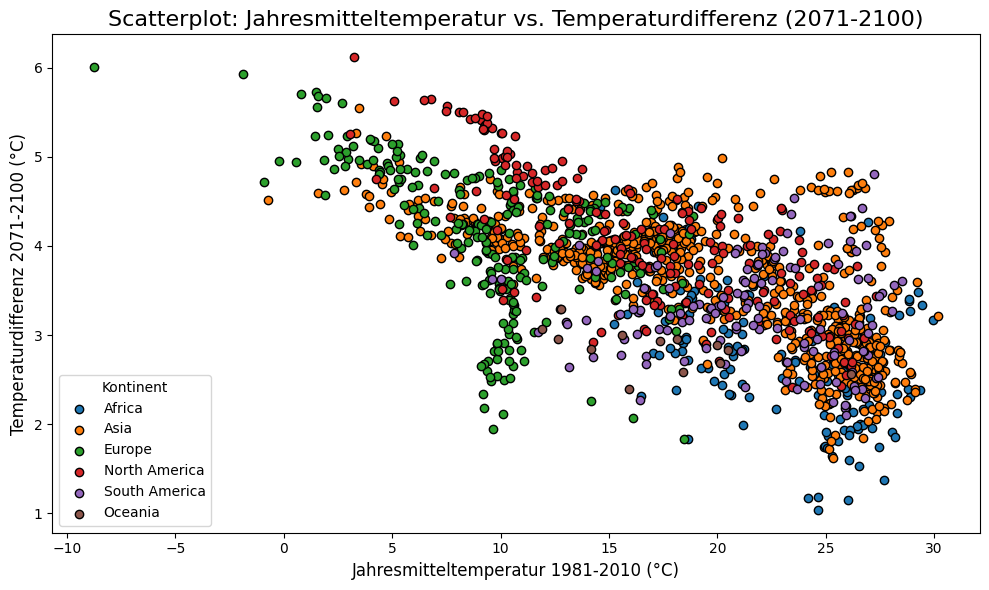

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtern, um nur die Zeilen mit Temp_Type "tas" zu verwenden
result_df_tas = result_df[result_df['Temp_Type'] == 'tas']

# Berechne die Jahresmitteltemperatur für die Zeiträume 1981-2010 und 2071-2100, indem du den Mittelwert über die Monate nimmst
mean_temps_1981_2010 = result_df_tas.groupby('City')['Temp_1981_2010'].mean().reset_index()
mean_temps_2071_2100 = result_df_tas.groupby('City')['Temp_2071_2100'].mean().reset_index()

# Benenne die Spalten um, um Verwechslungen zu vermeiden
mean_temps_1981_2010.columns = ['City', 'Mean_1981_2010']
mean_temps_2071_2100.columns = ['City', 'Mean_2071_2100']

# Führe die beiden DataFrames zusammen, um die Temperaturdifferenzen zu berechnen
mean_temps = pd.merge(mean_temps_1981_2010, mean_temps_2071_2100, on='City')

# Berechne die Differenz zwischen den Zeiträumen
mean_temps['Temp_Diff_2071_2100'] = mean_temps['Mean_2071_2100'] - mean_temps['Mean_1981_2010']

# Füge die Kontinent-Informationen aus dem ursprünglichen DataFrame hinzu
mean_temps = pd.merge(mean_temps, result_df_tas[['City', 'Continent']].drop_duplicates(), on='City')

# Farben für die Kontinente festlegen
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}
#    'Antarctica': '#e377c2',
#    'Unknown': '#7f7f7f'

# Scatterplot erstellen
plt.figure(figsize=(10, 6))

# Zeichne den Scatterplot mit Jahresmitteltemperatur (1981-2010) auf der x-Achse und der Temperaturdifferenz auf der y-Achse
# Wir färben die Punkte nach Kontinenten ein
for continent, color in continent_palette.items():
    continent_data = mean_temps[mean_temps['Continent'] == continent]
    plt.scatter(continent_data['Mean_1981_2010'], continent_data['Temp_Diff_2071_2100'],
                alpha=1, edgecolor='black', label=continent, color=color)

# Achsenbeschriftungen und Titel
plt.title('Scatterplot: Jahresmitteltemperatur vs. Temperaturdifferenz (2071-2100)', fontsize=16)
plt.xlabel('Jahresmitteltemperatur 1981-2010 (°C)', fontsize=12)
plt.ylabel('Temperaturdifferenz 2071-2100 (°C)', fontsize=12)

# Legende hinzufügen
plt.legend(title='Kontinent', loc='lower left')

# Layout optimieren
plt.tight_layout()

# Plot anzeigen
plt.show()


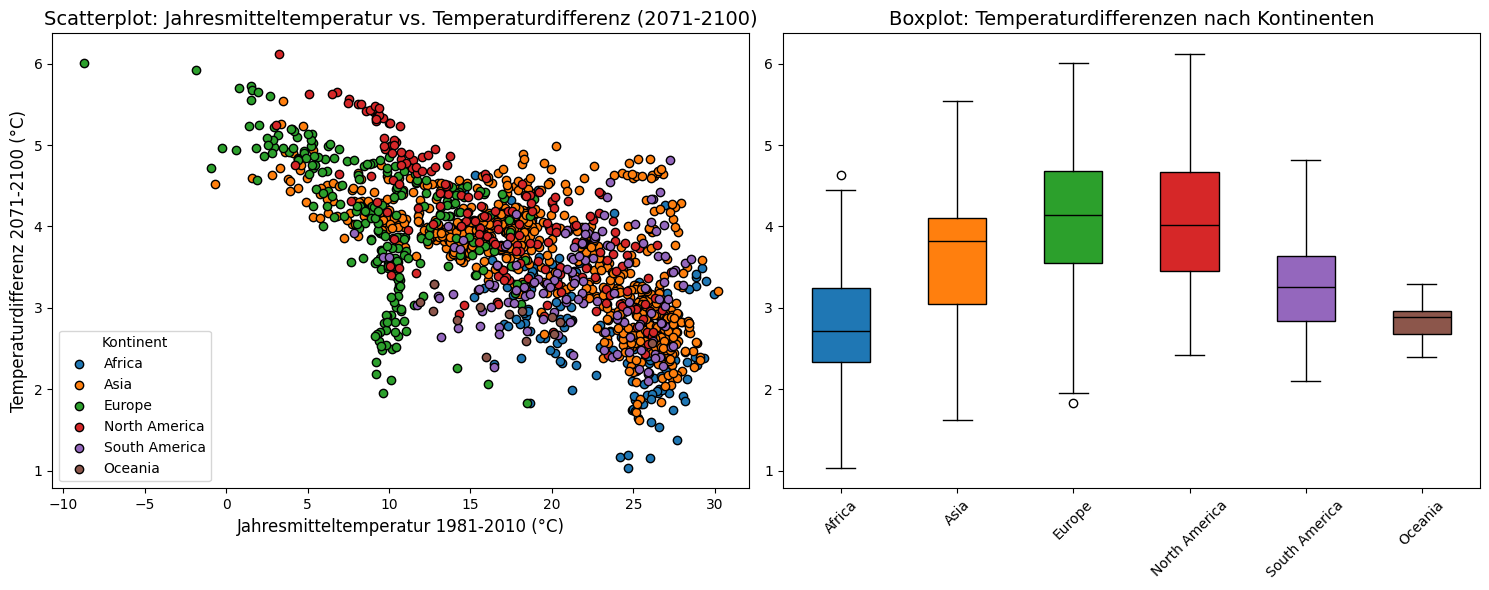

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtern, um nur die Zeilen mit Temp_Type "tas" zu verwenden
result_df_tas = result_df[result_df['Temp_Type'] == 'tas']

# Berechne die Jahresmitteltemperatur für die Zeiträume 1981-2010 und 2071-2100, indem du den Mittelwert über die Monate nimmst
mean_temps_1981_2010 = result_df_tas.groupby('City')['Temp_1981_2010'].mean().reset_index()
mean_temps_2071_2100 = result_df_tas.groupby('City')['Temp_2071_2100'].mean().reset_index()

# Benenne die Spalten um, um Verwechslungen zu vermeiden
mean_temps_1981_2010.columns = ['City', 'Mean_1981_2010']
mean_temps_2071_2100.columns = ['City', 'Mean_2071_2100']

# Führe die beiden DataFrames zusammen, um die Temperaturdifferenzen zu berechnen
mean_temps = pd.merge(mean_temps_1981_2010, mean_temps_2071_2100, on='City')

# Berechne die Differenz zwischen den Zeiträumen
mean_temps['Temp_Diff_2071_2100'] = mean_temps['Mean_2071_2100'] - mean_temps['Mean_1981_2010']

# Füge die Kontinent-Informationen aus dem ursprünglichen DataFrame hinzu
mean_temps = pd.merge(mean_temps, result_df_tas[['City', 'Continent']].drop_duplicates(), on='City')

# Farben für die Kontinente festlegen
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Subplots erstellen: 1 Reihe, 2 Spalten
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatterplot (linker Plot)
for continent, color in continent_palette.items():
    continent_data = mean_temps[mean_temps['Continent'] == continent]
    axes[0].scatter(continent_data['Mean_1981_2010'], continent_data['Temp_Diff_2071_2100'],
                    alpha=1, edgecolor='black', label=continent, color=color)

# Achsenbeschriftungen und Titel für Scatterplot
axes[0].set_title('Scatterplot: Jahresmitteltemperatur vs. Temperaturdifferenz (2071-2100)', fontsize=14)
axes[0].set_xlabel('Jahresmitteltemperatur 1981-2010 (°C)', fontsize=12)
axes[0].set_ylabel('Temperaturdifferenz 2071-2100 (°C)', fontsize=12)

# Legende zum Scatterplot hinzufügen
axes[0].legend(title='Kontinent', loc='lower left')

# Boxplots (rechter Plot)
# Erstelle Boxplots für die Temperaturdifferenzen der einzelnen Kontinente
mean_temps['Color'] = mean_temps['Continent'].map(continent_palette)  # Farbe den Kontinenten zuordnen

# Boxplot erstellen
for continent, color in continent_palette.items():
    continent_data = mean_temps[mean_temps['Continent'] == continent]
    axes[1].boxplot(continent_data['Temp_Diff_2071_2100'], 
                    positions=[list(continent_palette.keys()).index(continent)],
                    widths=0.5,
                    patch_artist=True, 
                    boxprops=dict(facecolor=color, color='black'), 
                    medianprops=dict(color='black'))

# Achsenbeschriftungen und Titel für Boxplot
axes[1].set_title('Boxplot: Temperaturdifferenzen nach Kontinenten', fontsize=14)
#axes[1].set_ylabel('Temperaturdifferenz 2071-2100 (°C)', fontsize=12)
axes[1].set_xticks(range(len(continent_palette)))
axes[1].set_xticklabels(continent_palette.keys(), rotation=45)

# Layout optimieren und Plot anzeigen
plt.tight_layout()
plt.show()


In [6]:
# Erstelle Listen für Städte mit einer mittleren Temperatur über 29°C für die vier Zeiträume

# Zeiträume: 1981-2010, 2011-2040, 2041-2070, 2071-2100
cities_over_29_1981_2010 = result_df_tas[result_df_tas['Temp_1981_2010'] > 29]['City'].unique().tolist()
cities_over_29_2011_2040 = result_df_tas[result_df_tas['Temp_2011_2040'] > 29]['City'].unique().tolist()
cities_over_29_2041_2070 = result_df_tas[result_df_tas['Temp_2041_2070'] > 29]['City'].unique().tolist()
cities_over_29_2071_2100 = result_df_tas[result_df_tas['Temp_2071_2100'] > 29]['City'].unique().tolist()

# Ausgabe der Ergebnisse
print("Städte mit einer mittleren Temperatur über 29°C im Zeitraum 1981-2010:", cities_over_29_1981_2010)
print("Städte mit einer mittleren Temperatur über 29°C im Zeitraum 2011-2040:", cities_over_29_2011_2040)
print("Städte mit einer mittleren Temperatur über 29°C im Zeitraum 2041-2070:", cities_over_29_2041_2070)
print("Städte mit einer mittleren Temperatur über 29°C im Zeitraum 2071-2100:", cities_over_29_2071_2100)


Städte mit einer mittleren Temperatur über 29°C im Zeitraum 1981-2010: ['Juba', 'Makurdi', 'Lokoja', 'Abu Zaby (Abu Dhabi)', 'Acapulco de JuÃ¡rez', 'Ad-Dammam', 'Ad-Dawhah (Doha)Ad-Dawhah (Doha) Ar-Rayyan', 'Ahmadnagar', 'Ahvaz', 'Dubayy (Dubai) Sharjah Ajman', 'Ajmer', 'Al-Ain', 'Al-Basrah (Basra)', 'Al Gadarif', 'Al-Hudaydah', 'Aligarh', 'Al-Khartum (Khartoum)', 'Allahabad', 'Al-Madinah (Medina)', 'Al-Mukalla', 'Al Obeid (Al Ubayyid)', 'Alwar', 'Amara', 'Amritsar', 'Anantapur', 'Ar-Riyadh (Riyadh)', 'Aswan', 'Aurangabad', 'Baaqoobah', 'Baghdad', 'Bago', 'Baharampur', 'Bahawalpur', 'Bamako', 'Bandar Abbas', 'Bareilly', 'Barisal', 'Bathinda', 'Begusarai', 'Bellary', 'Berbera', 'Bhagalpur', 'Bhilwara', 'Mumbai (Bombay) Bhiwandi', 'Bhopal', 'Bhubaneswar', 'Bijapur', 'Bikaner', 'Bilaspur', 'Bobo-Dioulasso', 'Brahmapur', 'Buraydah', 'Chandrapur', 'Chennai (Madras)', 'Darbhanga', 'Delhi', 'Dera Ghazikhan', 'Dindigul', 'Diwaniyah', 'Durgapur', 'English Bazar', 'Faisalabad', 'Faloojah', 'Farr

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_26740/1890065035.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(pop_over_29_2011_2040['Continent'], rotation=45)
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_26740/1890065035.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(pop_over_29_2041_2070['Continent'], rotation=45)
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_26740/1890065035.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(pop_over_29_2071_2100['Continent'], rotation=45)


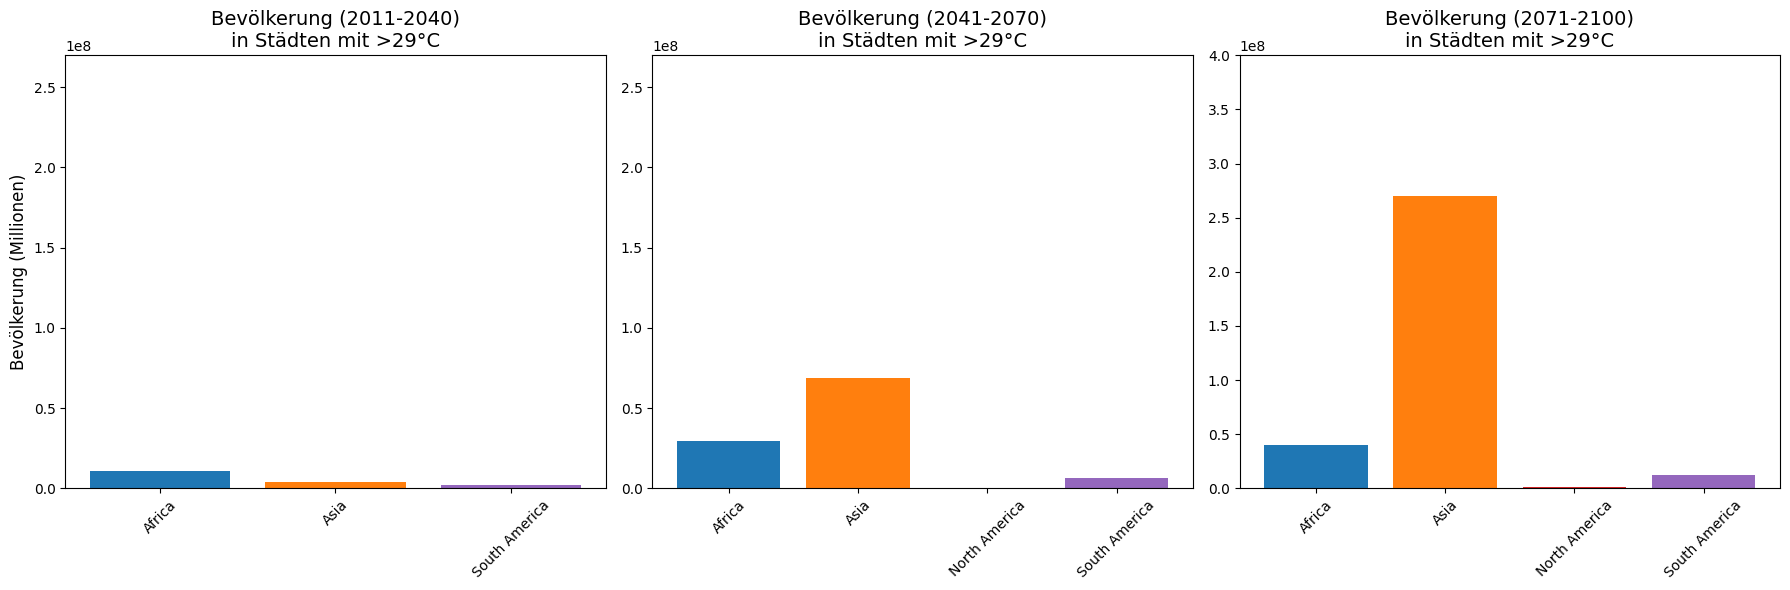

In [68]:
# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'Temp_2011_2040': 'mean',
    'Temp_2041_2070': 'mean',
    'Temp_2071_2100': 'mean',
    'SSP5_2020s': 'mean',
    'SSP5_2070s': 'mean',
    'SSP5_2100s': 'mean',
    'Continent': 'first'  # Kontinent bleibt gleich, daher nehmen wir den ersten Wert
}).reset_index()

# Filtern der Städte, deren mittlere Temperaturen in den jeweiligen Zeiträumen über 29°C liegen
cities_over_29_2011_2040 = mean_temps_per_city[mean_temps_per_city['Temp_2011_2040'] > 29]
cities_over_29_2041_2070 = mean_temps_per_city[mean_temps_per_city['Temp_2041_2070'] > 29]
cities_over_29_2071_2100 = mean_temps_per_city[mean_temps_per_city['Temp_2071_2100'] > 29]

# Gruppierung nach Kontinent und Summierung der Bevölkerungen für die Zeiträume
pop_over_29_2011_2040 = cities_over_29_2011_2040.groupby('Continent')['SSP5_2020s'].sum().reset_index()
pop_over_29_2041_2070 = cities_over_29_2041_2070.groupby('Continent')['SSP5_2070s'].sum().reset_index()
pop_over_29_2071_2100 = cities_over_29_2071_2100.groupby('Continent')['SSP5_2100s'].sum().reset_index()

# Maximalen y-Wert bestimmen, um die gleiche Skalierung für alle Plots zu verwenden
max_population = max(
    pop_over_29_2011_2040['SSP5_2020s'].max(),
    pop_over_29_2041_2070['SSP5_2070s'].max(),
    pop_over_29_2071_2100['SSP5_2100s'].max()
)

# Plotting: Drei Histogramme nebeneinander mit gleicher y-Skalierung
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Farben für die Kontinente (wie oben definiert)
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b',
    'Antarctica': '#e377c2',
    'Unknown': '#7f7f7f'
}

# Plot 1: Bevölkerung in Städten mit mehr als 29°C in 2011-2040
axes[0].bar(pop_over_29_2011_2040['Continent'], pop_over_29_2011_2040['SSP5_2020s'],
            color=[continent_palette[cont] for cont in pop_over_29_2011_2040['Continent']])
axes[0].set_title('Bevölkerung (2011-2040)\nin Städten mit >29°C', fontsize=14)
axes[0].set_ylabel('Bevölkerung (Millionen)', fontsize=12)
axes[0].set_ylim(0, max_population)  # Einheitliche Skalierung
axes[0].set_xticklabels(pop_over_29_2011_2040['Continent'], rotation=45)

# Plot 2: Bevölkerung in Städten mit mehr als 29°C in 2041-2070
axes[1].bar(pop_over_29_2041_2070['Continent'], pop_over_29_2041_2070['SSP5_2070s'],
            color=[continent_palette[cont] for cont in pop_over_29_2041_2070['Continent']])
axes[1].set_title('Bevölkerung (2041-2070)\nin Städten mit >29°C', fontsize=14)
axes[1].set_ylim(0, max_population)  # Einheitliche Skalierung
axes[1].set_xticklabels(pop_over_29_2041_2070['Continent'], rotation=45)

# Plot 3: Bevölkerung in Städten mit mehr als 29°C in 2071-2100
axes[2].bar(pop_over_29_2071_2100['Continent'], pop_over_29_2071_2100['SSP5_2100s'],
            color=[continent_palette[cont] for cont in pop_over_29_2071_2100['Continent']])
axes[2].set_title('Bevölkerung (2071-2100)\nin Städten mit >29°C', fontsize=14)
axes[2].set_ylim(0, 4e8)  # Einheitliche Skalierung
axes[2].set_xticklabels(pop_over_29_2071_2100['Continent'], rotation=45)

# Layout optimieren und Plot anzeigen
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'Temp_2011_2040': 'mean',
    'Temp_2041_2070': 'mean',
    'Temp_2071_2100': 'mean',
    'SSP5_2020s': 'mean',
    'SSP5_2070s': 'mean',
    'SSP5_2100s': 'mean',
    'Continent': 'first'  # Kontinent bleibt gleich, daher nehmen wir den ersten Wert
}).reset_index()

# Gruppierung nach Kontinent, um die Gesamtanzahl der Städte, Gesamtbevölkerung und mittlere Bevölkerung pro Stadt zu berechnen
def calculate_population_stats(df, population_column):
    stats = df.groupby('Continent').agg(
        num_cities=('City', 'count'),                    # Anzahl der Städte
        total_population=(population_column, 'sum'),     # Gesamtbevölkerung
        mean_population_per_city=(population_column, 'mean')  # Mittlere Bevölkerung pro Stadt
    ).reset_index()
    return stats

# Berechnung der Statistiken für jeden Zeitraum
stats_2011_2040 = calculate_population_stats(mean_temps_per_city, 'SSP5_2020s')
stats_2041_2070 = calculate_population_stats(mean_temps_per_city, 'SSP5_2070s')
stats_2071_2100 = calculate_population_stats(mean_temps_per_city, 'SSP5_2100s')

# Zusammenführen der Statistiken in einer Tabelle (DataFrame)
final_table = pd.DataFrame({
    'Continent': stats_2011_2040['Continent'],
    'Num_Cities_2011_2040': stats_2011_2040['num_cities'],
    'Total_Pop_2011_2040': stats_2011_2040['total_population'],
    'Mean_Pop_per_City_2011_2040': stats_2011_2040['mean_population_per_city'],
    'Num_Cities_2041_2070': stats_2041_2070['num_cities'],
    'Total_Pop_2041_2070': stats_2041_2070['total_population'],
    'Mean_Pop_per_City_2041_2070': stats_2041_2070['mean_population_per_city'],
    'Num_Cities_2071_2100': stats_2071_2100['num_cities'],
    'Total_Pop_2071_2100': stats_2071_2100['total_population'],
    'Mean_Pop_per_City_2071_2100': stats_2071_2100['mean_population_per_city'],
})

# Ausgabe der finalen Tabelle
print(final_table)


       Continent  Num_Cities_2011_2040  Total_Pop_2011_2040  \
0         Africa                   168         1.944981e+08   
1           Asia                   792         1.048407e+09   
2         Europe                   227         1.699699e+08   
3  North America                   179         1.782706e+08   
4        Oceania                    13         1.585276e+07   
5  South America                   100         1.047161e+08   

   Mean_Pop_per_City_2011_2040  Num_Cities_2041_2070  Total_Pop_2041_2070  \
0                 1.157727e+06                   168         3.179929e+08   
1                 1.323747e+06                   792         1.137968e+09   
2                 7.487660e+05                   227         2.178841e+08   
3                 9.959251e+05                   179         2.545423e+08   
4                 1.219443e+06                    13         3.000398e+07   
5                 1.047161e+06                   100         9.287820e+07   

   Mean_Pop_per_Ci

In [24]:
import pandas as pd

# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'Temp_2011_2040': 'mean',
    'Temp_2041_2070': 'mean',
    'Temp_2071_2100': 'mean',
    'SSP5_2020s': 'mean',
    'SSP5_2070s': 'mean',
    'SSP5_2100s': 'mean',
    'Continent': 'first'  # Kontinent bleibt gleich, daher nehmen wir den ersten Wert
}).reset_index()

# Liste aller Kontinente aus den Daten
all_continents = result_df_tas['Continent'].unique()

# Funktion zur Berechnung der Statistiken
def calculate_population_stats(df, population_column):
    stats = df.groupby('Continent').agg(
        num_cities=('City', 'count'),                    # Anzahl der Städte
        total_population=(population_column, 'sum'),     # Gesamtbevölkerung
        mean_population_per_city=(population_column, 'mean')  # Mittlere Bevölkerung pro Stadt
    ).reset_index()
    # Sicherstellen, dass alle Kontinente in den Ergebnissen sind
    stats = pd.merge(pd.DataFrame({'Continent': all_continents}), stats, on='Continent', how='left')
    stats.fillna(0, inplace=True)  # Fülle fehlende Werte (NaN) mit 0
    return stats

# Filtern der Städte mit einer mittleren Jahrestemperatur von mehr als 29°C in den jeweiligen Zeiträumen
cities_over_29_2011_2040 = mean_temps_per_city[mean_temps_per_city['Temp_2011_2040'] > 29]
cities_over_29_2041_2070 = mean_temps_per_city[mean_temps_per_city['Temp_2041_2070'] > 29]
cities_over_29_2071_2100 = mean_temps_per_city[mean_temps_per_city['Temp_2071_2100'] > 29]

# Berechnung der Statistiken für jeden Zeitraum (nur Städte über 29°C)
stats_2011_2040 = calculate_population_stats(cities_over_29_2011_2040, 'SSP5_2020s')
stats_2041_2070 = calculate_population_stats(cities_over_29_2041_2070, 'SSP5_2070s')
stats_2071_2100 = calculate_population_stats(cities_over_29_2071_2100, 'SSP5_2100s')

# Zusammenführen der Statistiken in einer Tabelle (DataFrame)
final_table_over_29 = pd.DataFrame({
    'Continent': stats_2011_2040['Continent'],
    'Num_Cities_2011_2040': stats_2011_2040['num_cities'],
    'Total_Pop_2011_2040': stats_2011_2040['total_population'],
    'Mean_Pop_per_City_2011_2040': stats_2011_2040['mean_population_per_city'],
    'Num_Cities_2041_2070': stats_2041_2070['num_cities'],
    'Total_Pop_2041_2070': stats_2041_2070['total_population'],
    'Mean_Pop_per_City_2041_2070': stats_2041_2070['mean_population_per_city'],
    'Num_Cities_2071_2100': stats_2071_2100['num_cities'],
    'Total_Pop_2071_2100': stats_2071_2100['total_population'],
    'Mean_Pop_per_City_2071_2100': stats_2071_2100['mean_population_per_city'],
})

# Ausgabe der finalen Tabelle
print(final_table_over_29)


       Continent  Num_Cities_2011_2040  Total_Pop_2011_2040  \
0  North America                   0.0         0.000000e+00   
1         Africa                  10.0         1.094621e+07   
2           Asia                   6.0         4.003897e+06   
3  South America                   1.0         2.041722e+06   
4        Oceania                   0.0         0.000000e+00   
5         Europe                   0.0         0.000000e+00   

   Mean_Pop_per_City_2011_2040  Num_Cities_2041_2070  Total_Pop_2041_2070  \
0                 0.000000e+00                   1.0         3.439450e+05   
1                 1.094621e+06                  13.0         2.934848e+07   
2                 6.673162e+05                  36.0         6.884456e+07   
3                 2.041722e+06                   7.0         6.435463e+06   
4                 0.000000e+00                   0.0         0.000000e+00   
5                 0.000000e+00                   0.0         0.000000e+00   

   Mean_Pop_per_Ci

In [35]:
import pandas as pd

# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'Temp_2011_2040': 'mean',
    'Temp_2041_2070': 'mean',
    'Temp_2071_2100': 'mean',
    'SSP5_2020s': 'mean',
    'SSP5_2070s': 'mean',
    'SSP5_2100s': 'mean',
    'Continent': 'first'  # Kontinent bleibt gleich, daher nehmen wir den ersten Wert
}).reset_index()

# Liste aller Kontinente aus den Daten
all_continents = result_df_tas['Continent'].unique()

# Funktion zur Berechnung der Statistiken
def calculate_population_stats(df, population_column):
    stats = df.groupby('Continent').agg(
        num_cities=('City', 'count'),                    # Anzahl der Städte
        total_population=(population_column, 'sum'),     # Gesamtbevölkerung
        mean_population_per_city=(population_column, 'mean')  # Mittlere Bevölkerung pro Stadt
    ).reset_index()
    # Sicherstellen, dass alle Kontinente in den Ergebnissen sind
    stats = pd.merge(pd.DataFrame({'Continent': all_continents}), stats, on='Continent', how='left')
    stats.fillna(0, inplace=True)  # Fülle fehlende Werte (NaN) mit 0
    return stats

# Filtern der Städte mit einer mittleren Jahrestemperatur von 27-29°C in den jeweiligen Zeiträumen
cities_27_29_2011_2040 = mean_temps_per_city[(mean_temps_per_city['Temp_2011_2040'] >= 27) & (mean_temps_per_city['Temp_2011_2040'] <= 29)]
cities_27_29_2041_2070 = mean_temps_per_city[(mean_temps_per_city['Temp_2041_2070'] >= 27) & (mean_temps_per_city['Temp_2041_2070'] <= 29)]
cities_27_29_2071_2100 = mean_temps_per_city[(mean_temps_per_city['Temp_2071_2100'] >= 27) & (mean_temps_per_city['Temp_2071_2100'] <= 29)]

# Berechnung der Statistiken für jeden Zeitraum (nur Städte zwischen 27 und 29°C)
stats_2011_2040 = calculate_population_stats(cities_27_29_2011_2040, 'SSP5_2020s')
stats_2041_2070 = calculate_population_stats(cities_27_29_2041_2070, 'SSP5_2070s')
stats_2071_2100 = calculate_population_stats(cities_27_29_2071_2100, 'SSP5_2100s')

# Zusammenführen der Statistiken in einer Tabelle (DataFrame)
final_table_27_29 = pd.DataFrame({
    'Continent': stats_2011_2040['Continent'],
    'Num_Cities_2011_2040': stats_2011_2040['num_cities'],
    'Total_Pop_2011_2040': stats_2011_2040['total_population'],
    'Mean_Pop_per_City_2011_2040': stats_2011_2040['mean_population_per_city'],
    'Num_Cities_2041_2070': stats_2041_2070['num_cities'],
    'Total_Pop_2041_2070': stats_2041_2070['total_population'],
    'Mean_Pop_per_City_2041_2070': stats_2041_2070['mean_population_per_city'],
    'Num_Cities_2071_2100': stats_2071_2100['num_cities'],
    'Total_Pop_2071_2100': stats_2071_2100['total_population'],
    'Mean_Pop_per_City_2071_2100': stats_2071_2100['mean_population_per_city'],
})

# Ausgabe der finalen Tabelle
print(final_table_27_29)


       Continent  Num_Cities_2011_2040  Total_Pop_2011_2040  \
0  North America                   2.0         1.305508e+06   
1         Africa                  20.0         9.692150e+06   
2           Asia                 121.0         1.839625e+08   
3  South America                  16.0         1.249069e+07   
4        Oceania                   0.0         0.000000e+00   
5         Europe                   0.0         0.000000e+00   

   Mean_Pop_per_City_2011_2040  Num_Cities_2041_2070  Total_Pop_2041_2070  \
0                 6.527538e+05                   9.0         3.500305e+06   
1                 4.846075e+05                  46.0         9.496188e+07   
2                 1.520351e+06                 145.0         2.725504e+08   
3                 7.806681e+05                  20.0         1.362780e+07   
4                 0.000000e+00                   1.0         3.949010e+05   
5                 0.000000e+00                   0.0         0.000000e+00   

   Mean_Pop_per_Ci

In [26]:
# Ermittlung der nördlichsten und südlichsten Koordinaten
northernmost_point = result_df.loc[result_df['y-Koord'].idxmax()]
southernmost_point = result_df.loc[result_df['y-Koord'].idxmin()]

# Ausgabe der Stadt, des Landes und der Koordinaten
print("Nördlichster Punkt:")
print(northernmost_point[['City', 'Country', 'y-Koord']])

print("\nSüdlichster Punkt:")
print(southernmost_point[['City', 'Country', 'y-Koord']])


Nördlichster Punkt:
City              Arkhangelsk
Country    Russian Federation
y-Koord             64.604027
Name: 44151, dtype: object

Südlichster Punkt:
City       Christchurch
Country     New Zealand
y-Koord      -43.595972
Name: 129086, dtype: object


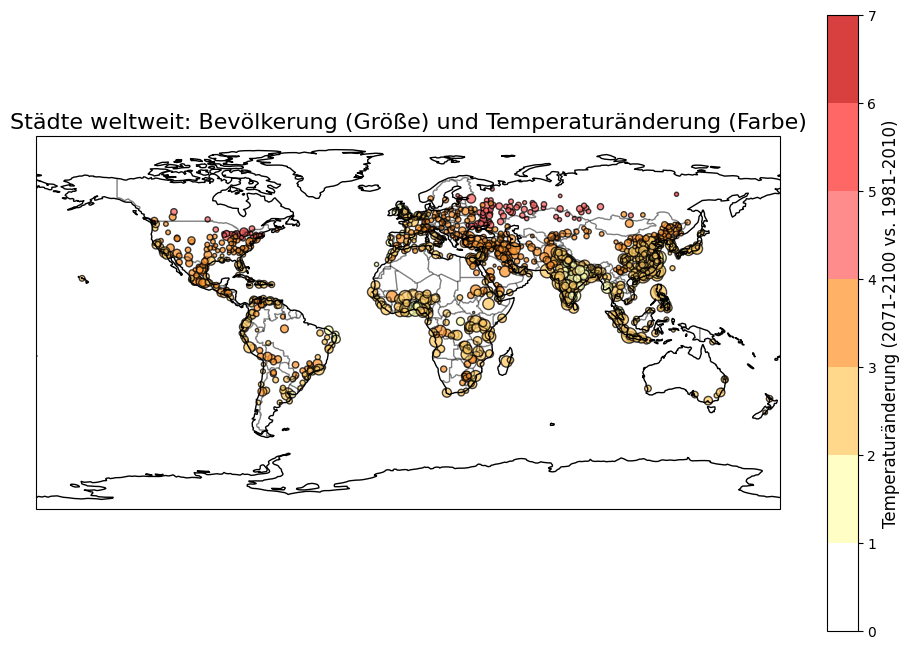

In [60]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # Das richtige Modul für geografische Features
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'x-Koord': 'median',
    'y-Koord': 'median',
    'Temp_1981_2010': 'mean',
    'Temp_2071_2100': 'mean',
    'SSP3_2100s': 'mean',
}).reset_index()

# Berechne die Temperaturänderung zwischen 1981-2010 und 2071-2100
mean_temps_per_city['Temp_Change'] = mean_temps_per_city['Temp_2071_2100'] - mean_temps_per_city['Temp_1981_2010']

# Erstelle eine diskrete Farbskala von Weiß bis Rot (0°C bis 7°C)
cmap = ListedColormap(['#ffffff', '#ffffb2', '#ffcc66', '#ff9933', '#ff6666', '#ff3333', '#cc0000'])
bounds = [0, 1, 2, 3, 4, 5, 6, 7]
norm = BoundaryNorm(bounds, cmap.N)

# Erstelle eine Weltkarte mit Cartopy
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Zeichne die Küstenlinien und Ländergrenzen
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)  # Korrekte Verwendung für Ländergrenzen

# Skalierung der Punktgröße basierend auf der Bevölkerung im Jahr 2100
population_size = np.sqrt(mean_temps_per_city['SSP3_2100s']) / 50  # Bevölkerung für 2100 skalieren

# Zeichne die Städte als Punkte auf die Karte
scatter = plt.scatter(mean_temps_per_city['x-Koord'], mean_temps_per_city['y-Koord'], 
                      s=population_size,  # Durchmesser basierend auf Bevölkerung
                      c=mean_temps_per_city['Temp_Change'],  # Farbe basierend auf der Temperaturänderung
                      cmap=cmap, norm=norm,  # Diskrete Farbskala Weiß bis Rot
                      alpha=0.75, edgecolor='k', transform=ccrs.PlateCarree())

# Farblegende für die Temperaturänderung hinzufügen
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05, ticks=bounds)
cbar.set_label('Temperaturänderung (2071-2100 vs. 1981-2010)', fontsize=12)

# Titel der Karte
plt.title('Städte weltweit: Bevölkerung (Größe) und Temperaturänderung (Farbe)', fontsize=16)

# Karte anzeigen
plt.show()


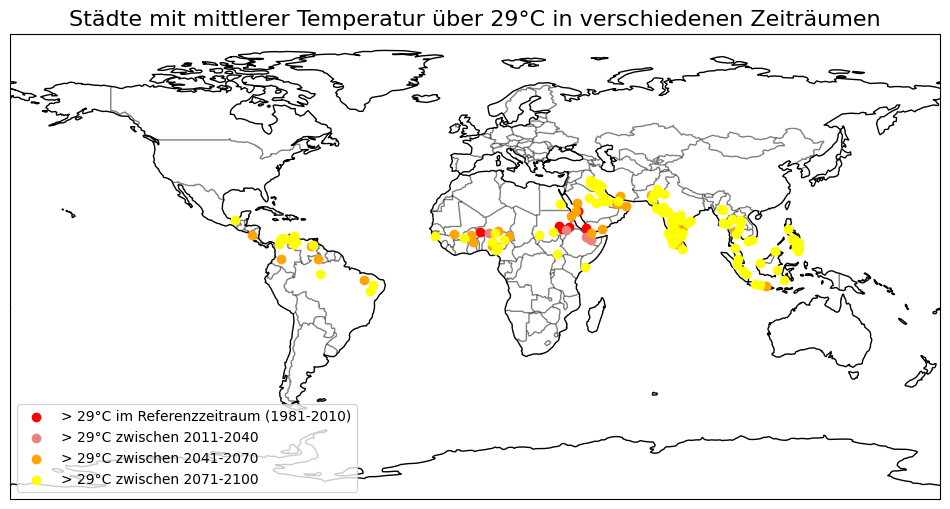

In [61]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

# Filtern auf nur 'tas'
result_df_tas = merged_with_shape[merged_with_shape['Temp_Type'] == 'tas']

# Berechne den Mittelwert der Temperaturen pro Stadt über die verschiedenen Pixel für jeden Zeitraum
mean_temps_per_city = result_df_tas.groupby('City').agg({
    'x-Koord': 'median',
    'y-Koord': 'median',
    'Temp_1981_2010': 'mean',
    'Temp_2011_2040': 'mean',
    'Temp_2041_2070': 'mean',
    'Temp_2071_2100': 'mean',
}).reset_index()

# Liste der Städte, die in jedem Zeitraum die 29°C überschreiten
cities_over_29_1981_2010 = mean_temps_per_city[mean_temps_per_city['Temp_1981_2010'] > 29]
cities_over_29_2011_2040 = mean_temps_per_city[(mean_temps_per_city['Temp_2011_2040'] > 29) & (mean_temps_per_city['Temp_1981_2010'] <= 29)]
cities_over_29_2041_2070 = mean_temps_per_city[(mean_temps_per_city['Temp_2041_2070'] > 29) & (mean_temps_per_city['Temp_2011_2040'] <= 29)]
cities_over_29_2071_2100 = mean_temps_per_city[(mean_temps_per_city['Temp_2071_2100'] > 29) & (mean_temps_per_city['Temp_2041_2070'] <= 29)]

# Erstelle eine Weltkarte mit Cartopy
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Zeichne die Küstenlinien und Ländergrenzen
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)  # Ländergrenzen

# Zeichne die Städte in verschiedenen Farben je nach Zeitraum
# Rot für Städte, die bereits im Referenzzeitraum > 29°C sind
plt.scatter(cities_over_29_1981_2010['x-Koord'], cities_over_29_1981_2010['y-Koord'],
            color='red', label='> 29°C im Referenzzeitraum (1981-2010)', transform=ccrs.PlateCarree(), zorder=5)

# Hellrot für Städte, die zwischen 2011 und 2040 > 29°C sind
plt.scatter(cities_over_29_2011_2040['x-Koord'], cities_over_29_2011_2040['y-Koord'],
            color='lightcoral', label='> 29°C zwischen 2011-2040', transform=ccrs.PlateCarree(), zorder=5)

# Orange für Städte, die zwischen 2041 und 2070 > 29°C sind
plt.scatter(cities_over_29_2041_2070['x-Koord'], cities_over_29_2041_2070['y-Koord'],
            color='orange', label='> 29°C zwischen 2041-2070', transform=ccrs.PlateCarree(), zorder=5)

# Gelb für Städte, die zwischen 2071 und 2100 > 29°C sind
plt.scatter(cities_over_29_2071_2100['x-Koord'], cities_over_29_2071_2100['y-Koord'],
            color='yellow', label='> 29°C zwischen 2071-2100', transform=ccrs.PlateCarree(), zorder=5)

# Legende hinzufügen
plt.legend(loc='lower left')

# Titel der Karte
plt.title('Städte mit mittlerer Temperatur über 29°C in verschiedenen Zeiträumen', fontsize=16)

# Karte anzeigen
plt.show()
